## Titanic Machine Learning from Disaster Kaggle Exercise


Data downloaded from Kaggle is grouped into: test and train dataset as well as a gender_submission file which shows if a passenger with a certain ID has survived

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


### Exploratory Data Analysis

In [3]:
#Load and read data
train_df = pd.read_csv("../data/train.csv")
train_df.head(5)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [105]:
train_df.describe()
print(train_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


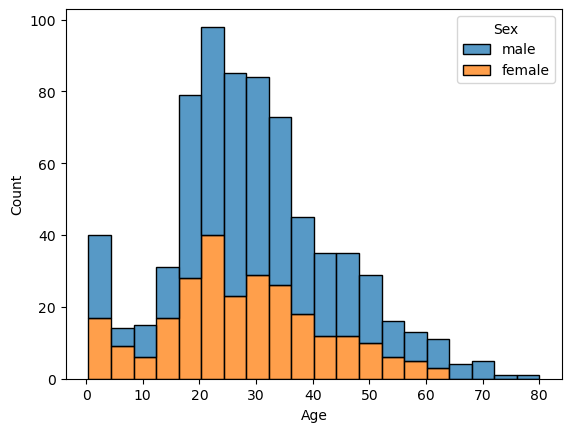

In [5]:
#to achieve clean preprocessing the following methods will be used to handle the missing values:
#for Age which is mostly normally distributed, the mean could also be used to fill
#for the Cabin, the column will be dropped as it won't be relevant for a tree based classification model
#The rows in embarked will be removed as it will not change our distribution or influence out results strongly

#Show Histograms for distributions

sns.histplot(data=train_df, x="Age", hue="Sex", bins=20, multiple="stack")
plt.show()

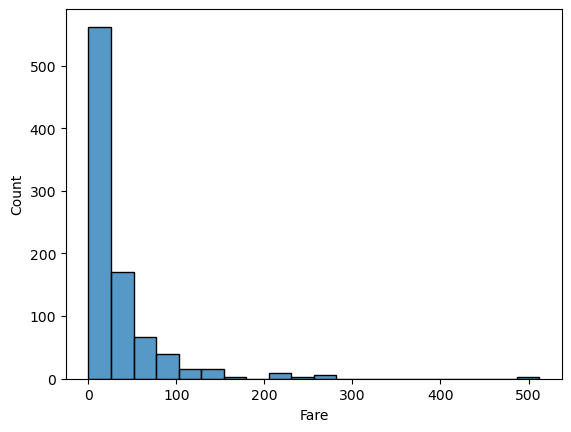

In [6]:
sns.histplot(data=train_df,x="Fare",bins=20)
plt.show()

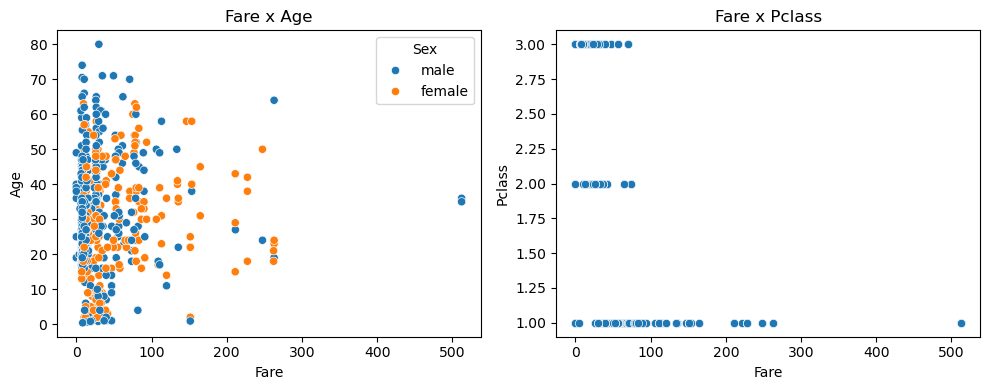

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=train_df, x="Fare", y="Age", hue="Sex", ax=axes[0])
axes[0].set_title("Fare x Age")

sns.scatterplot(data=train_df, x="Fare", y="Pclass", ax=axes[1])
axes[1].set_title("Fare x Pclass")

plt.tight_layout()
plt.show()


In [8]:
#Tree based model makes sense because there does not seem to be multicollinearity on first glace 
#will be checked later using statistical methods
#we have non-linear data which works fine with tree based models

In [ ]:
train_df_proc = train_df[["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]]
train_df_proc = train_df_proc.copy()
train_df_proc["Sex"] = np.where(train_df_proc["Sex"] == "male", 0, 1)
#male
train_df_proc["Age"] = np.where(
    (train_df_proc["Age"].isna()) & (train_df_proc["Sex"] == 0),
    train_df_proc["Age"].fillna(train_df_proc.loc[train_df_proc["Sex"] == 0, "Age"].mean()),
    train_df_proc["Age"]
)
#female
train_df_proc["Age"] = np.where(
    (train_df_proc["Age"].isna()) & (train_df_proc["Sex"] == 1),
    train_df_proc["Age"].fillna(train_df_proc.loc[train_df_proc["Sex"] == 1, "Age"].mean()),
    train_df_proc["Age"]
)
train_df_proc = train_df_proc.dropna(subset=["Embarked"])
train_df_proc["Embarked"] = train_df_proc["Embarked"].map({"C":0,"Q":1,"S":2})
print(train_df_proc.isna().sum())
train_df_proc.describe()



Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.350956,29.690446,0.524184,0.382452,32.096681,1.535433
std,0.486260,0.834700,0.477538,12.981441,1.103705,0.806761,49.697504,0.792088
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,1.000000
50%,0.000000,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [ ]:
def preprocessing_function(df):
    columns = ["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
    if "Survived" in df.columns:
        columns = ["Survived"] + columns
    preproc_df = df[columns].copy()
    preproc_df["Sex"] = np.where(preproc_df["Sex"] == "male", 0, 1)

    preproc_df["Age"] = preproc_df["Age"].fillna(
    preproc_df.groupby("Sex")["Age"].transform("mean")
    )
    return preproc_df
train_df_proc = preprocessing_function(df=train_df)
    

In [10]:
#age mean stayed the same and variance decreased slightly

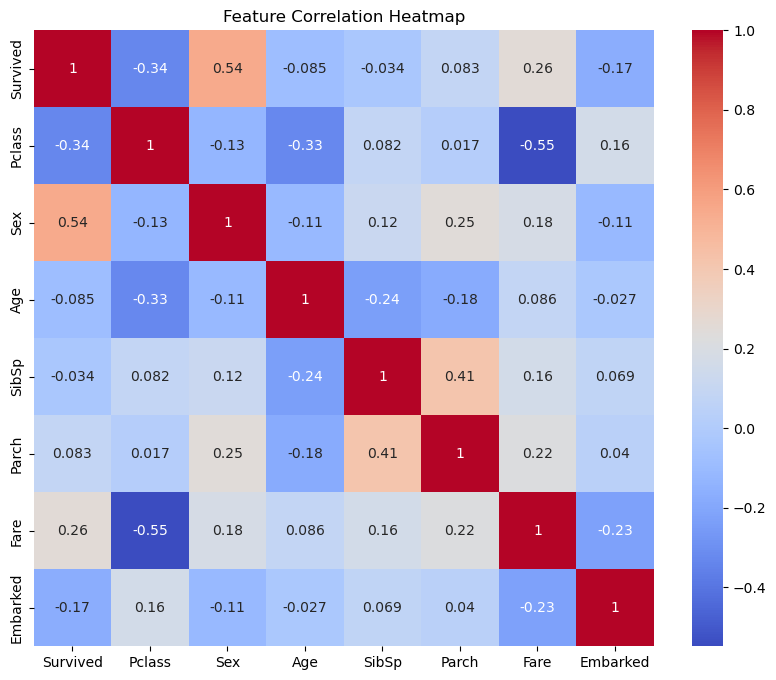

In [104]:
#check for multicollinearity
corr = train_df_proc.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#comment for myself: would've needed to set a cutoff correlation before hand because now we have
#peeking bias ;-; 

In [12]:
#build model, do not have to do test train split because we already have that

In [98]:
Tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=42)
X = train_df_proc.drop(columns="Survived")
y = train_df_proc["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8,random_state=42)


In [99]:
Tree_model.fit(X_train,y_train)
y_pred = Tree_model.predict(X_test)

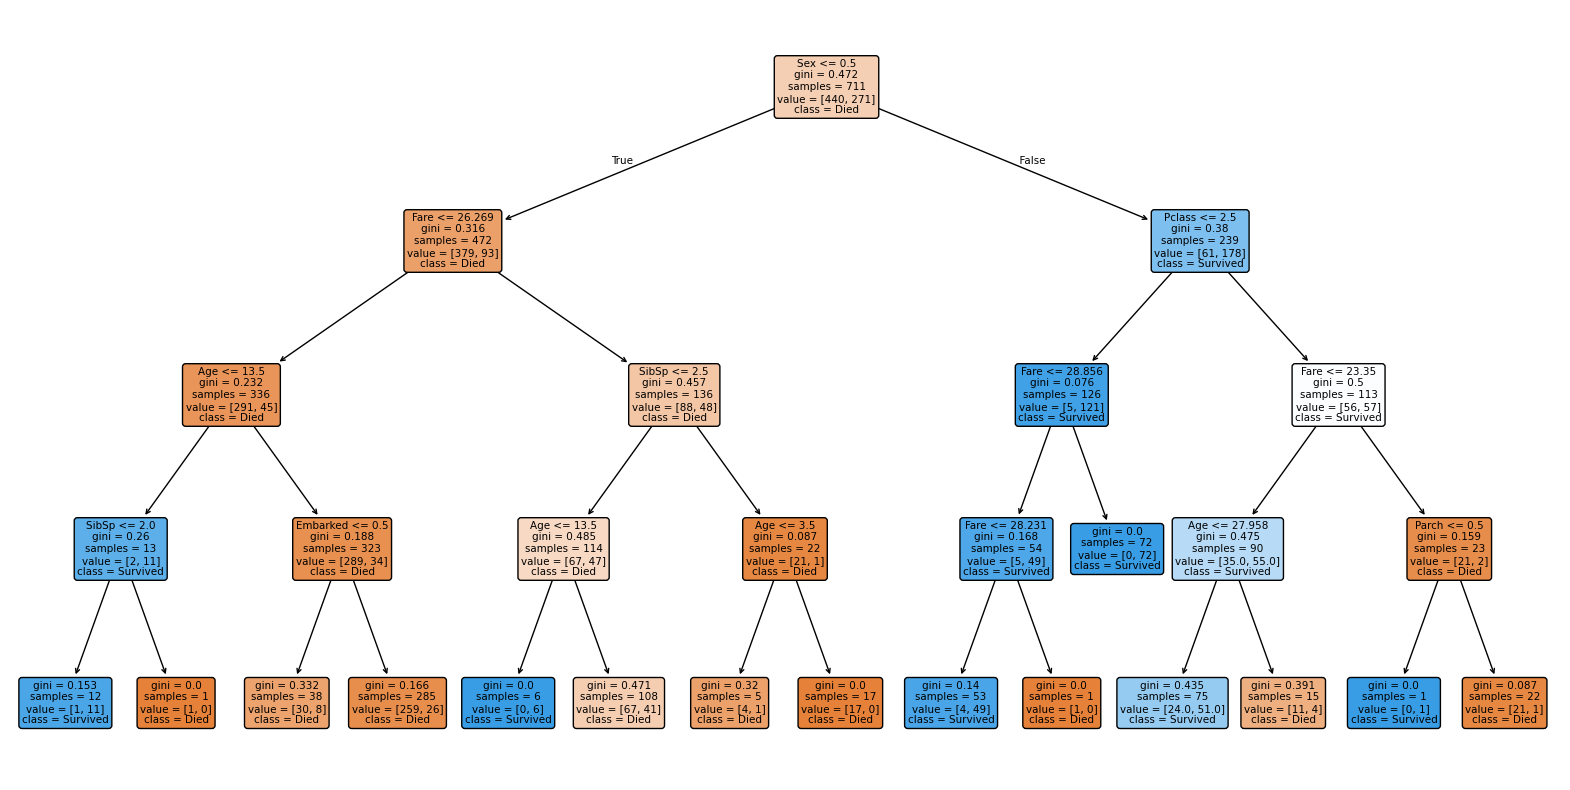

In [100]:
plt.figure(figsize=(20,10))
tree.plot_tree(
    Tree_model,                      
    feature_names=X_train.columns,   
    class_names=["Died", "Survived"],
    filled=True,                     
    rounded=True                    
)
plt.show()

Accuracy: 0.8258


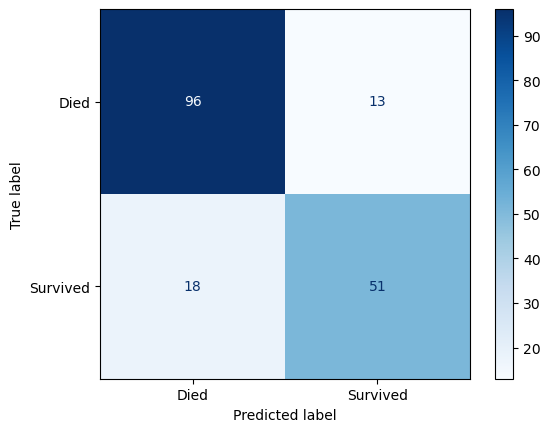

              precision    recall  f1-score   support

        Died       0.84      0.88      0.86       109
    Survived       0.80      0.74      0.77        69

    accuracy                           0.83       178
   macro avg       0.82      0.81      0.81       178
weighted avg       0.82      0.83      0.82       178



In [102]:
#Evaluate model
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy: {accuracy:.4f}")
#with depth of 3 we get an accuracy of 82%
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Died", "Survived"])
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, y_pred, target_names=["Died", "Survived"]))


Try to bin Age into 4 distinct age groups and the fare into quantiles and combine the SibSp and Parch columns into one to for checking if it has any effect on our model

In [64]:
bins = [0,12,19,59,80]
#0: Child, 1:Teen 2:Adult 3:Senior
train_df_proc_2 = train_df_proc.copy()
train_df_proc_2["Age"] = pd.cut(train_df_proc["Age"],bins=bins,labels=False)
train_df_proc_2["Fare"] = pd.qcut(train_df_proc["Fare"],q=5,labels=False)
train_df_proc_2["Fam_Size"] = train_df_proc_2["SibSp"] + train_df_proc_2["Parch"] + 1 # +1 to include the person themselves
#print(train_df_proc_2["Fam_Size"].max())
train_df_proc_2["Fam_Bin"] = pd.cut(train_df_proc_2["Fam_Size"],bins=[0,1,3,6,11],labels=False)
print(train_df_proc_2["Fam_Bin"].max())
train_df_proc_2.head()


3


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fam_Size,Fam_Bin
0,0,3,0,2.0,1,0,0,2,2,1
1,1,1,1,2.0,1,0,4,0,2,1
2,1,3,1,2.0,0,0,1,2,1,0
3,1,1,1,2.0,1,0,4,2,2,1
4,0,3,0,2.0,0,0,1,2,1,0


In [86]:
Tree_model_2 = DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=42)
X_2 = train_df_proc_2.drop(columns="Survived")
y_2 = train_df_proc_2["Survived"]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2,test_size=0.2,train_size=0.8,random_state=42)

In [87]:
Tree_model_2.fit(X_train_2,y_train_2)
y_pred_2 = Tree_model_2.predict(X_test_2)


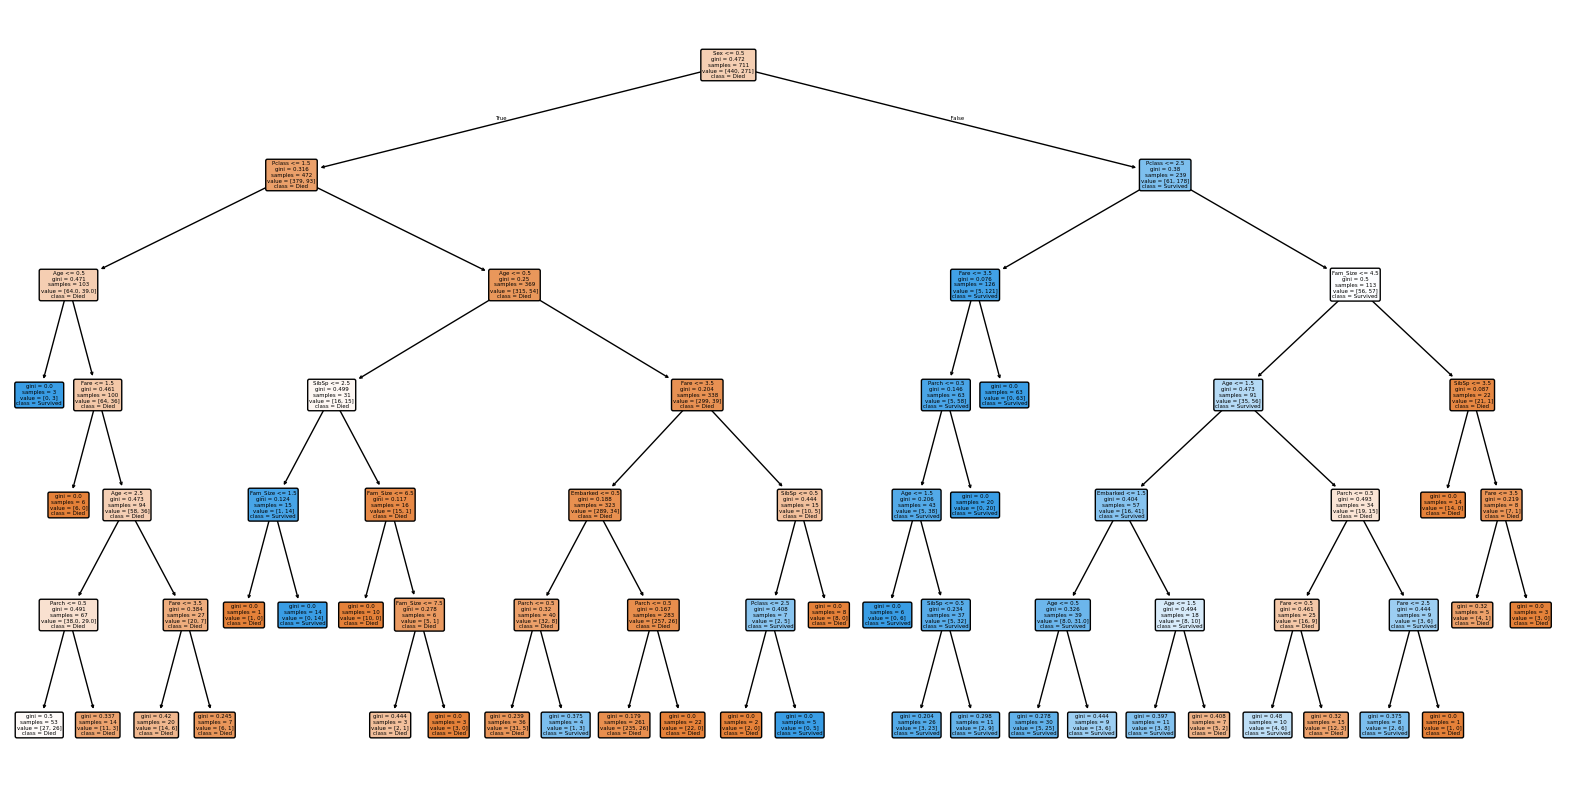

In [84]:
plt.figure(figsize=(20,10))
tree.plot_tree(
    Tree_model_2,                      
    feature_names=X_train_2.columns,   
    class_names=["Died", "Survived"],
    filled=True,                     
    rounded=True                    
)
plt.show()

Accuracy: 0.8202


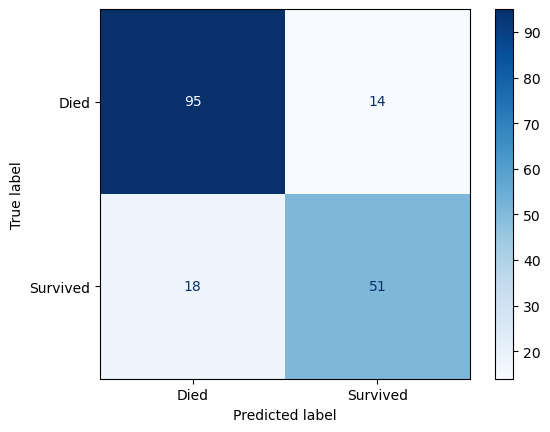

              precision    recall  f1-score   support

        Died       0.84      0.87      0.86       109
    Survived       0.78      0.74      0.76        69

    accuracy                           0.82       178
   macro avg       0.81      0.81      0.81       178
weighted avg       0.82      0.82      0.82       178



In [88]:
#Evaluate model
accuracy = accuracy_score(y_test_2,y_pred_2)
print(f"Accuracy: {accuracy:.4f}")
#with depth of 3 we get an accuracy of 82%
cm = confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Died", "Survived"])
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test_2, y_pred_2, target_names=["Died", "Survived"]))


After binning, the model requires a deeper tree depth to achieve a similar accuracy as the model without binning. This suggests that the model needs to "re-evaluate" our binned data to reconstruct the information and relationships lost to binning the data.